# 3D Poisson Problem

In [2]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS

# Additional Visualization Imports
import matplotlib.pyplot as plt
from skfem.visuals.matplotlib import draw

## Step 1: Create FEMSystem Object with Mesh and Element

Transforming over 1000 elements to C_CONTIGUOUS.


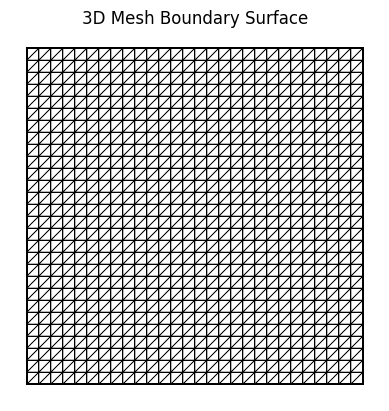

In [3]:
mesh = fem.MeshTet.init_tensor(
    jnp.linspace(0, 1, 8),
    jnp.linspace(0, 1, 8),
    jnp.linspace(0, 1, 8)
).refined(2)
element = fem.ElementTetP1()
intorder = 3

# 2. Initialize FEMSystem
femsystem = FEMSystem(mesh, element, intorder)

'''
Visualizing the Mesh
'''

# 1. Extract Boundary Surface
# Get indices of facets on the boundary
bnd_facets_indices = mesh.boundary_facets()

# Create a 2D MeshTri representing the surface of the 3D mesh
# mesh.facets contains the node indices for all faces
# We select only those on the boundary
bnd_mesh = fem.MeshTri(mesh.p, mesh.facets[:, bnd_facets_indices])

# 2. Draw the Boundary
fig = draw(bnd_mesh)
plt.title("3D Mesh Boundary Surface")
plt.show()

# Step 2: Define Optimization Objective (and Visualize the Potential)

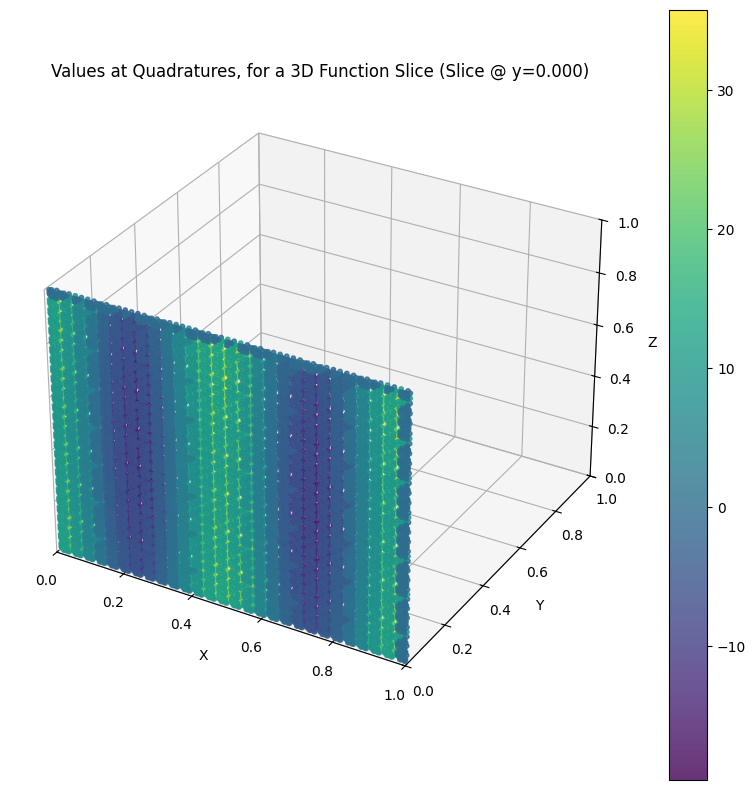

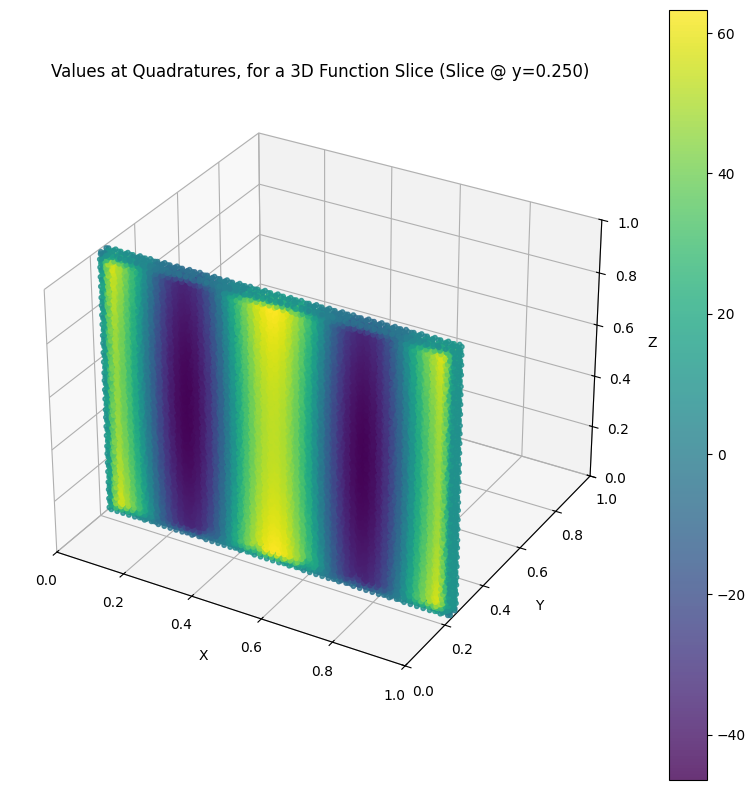

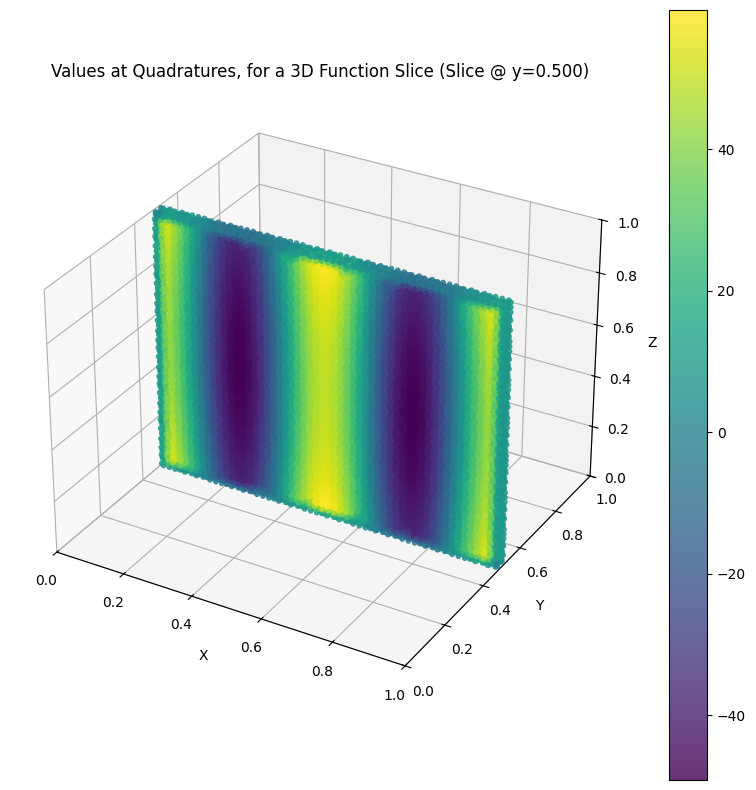

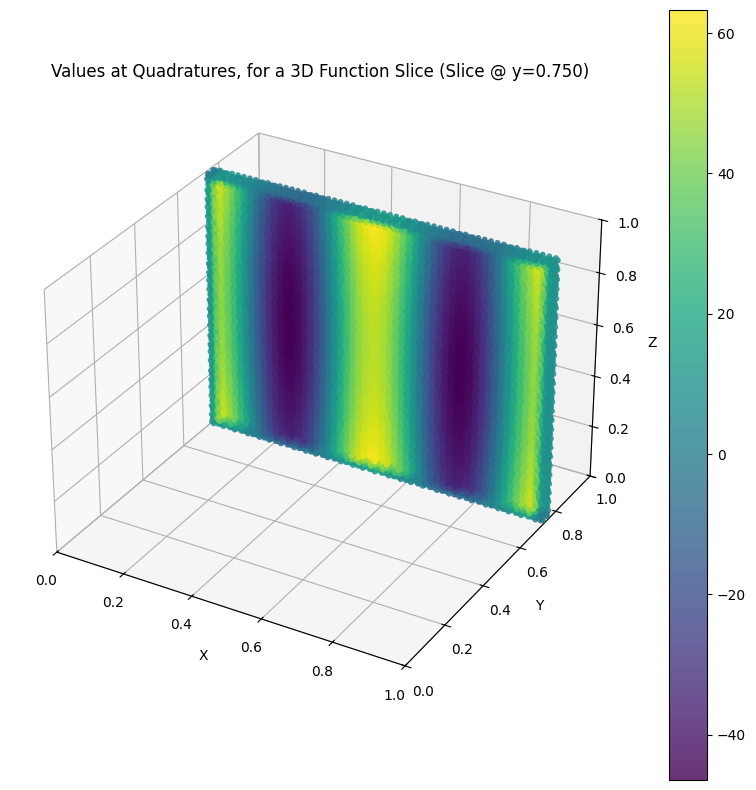

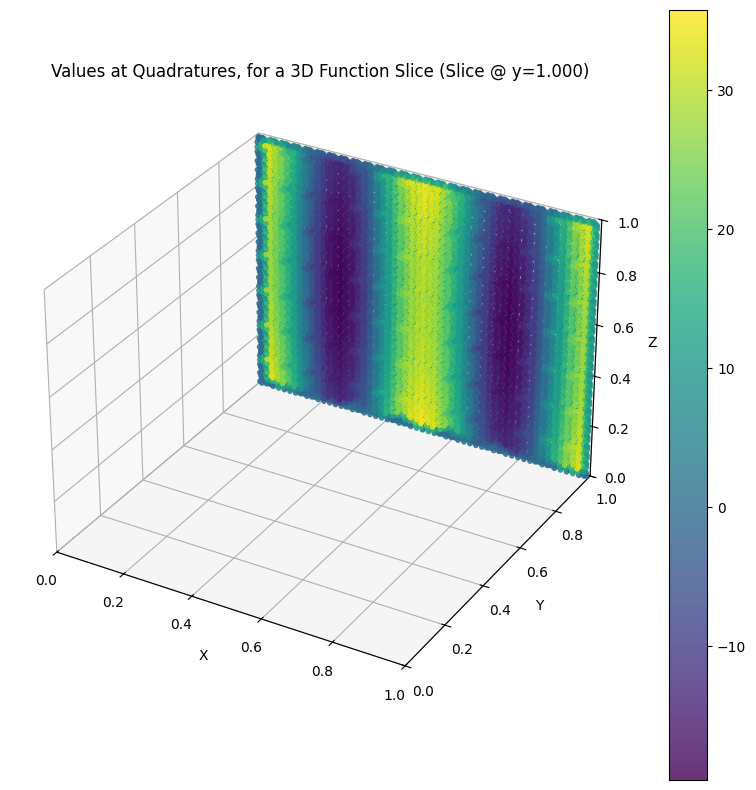

TypeError: float() argument must be a string or a number, not 'function'

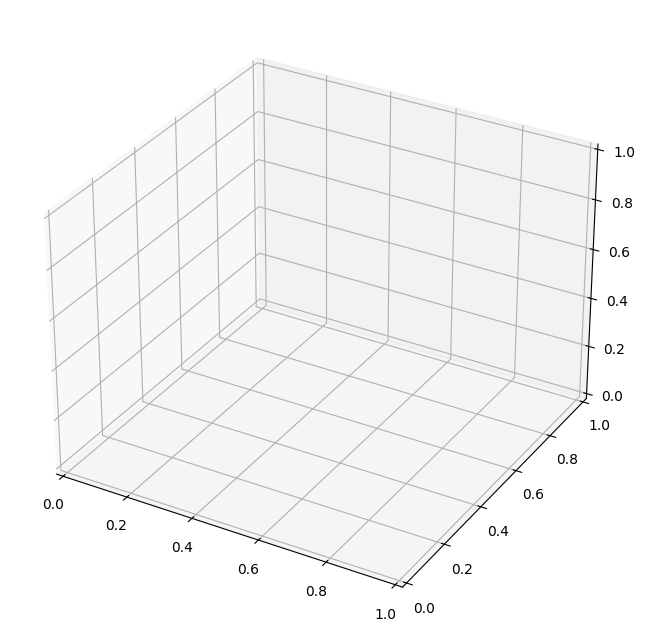

: 

In [ ]:
# 3. Define a Test Function u(x,y,z)
def v_3d(x, y, z):
    # k/2 * r^2
    r2 = jnp.cos(4*jnp.pi*x) + (y - 0.5)**2 + (z - 0.5)**2
    return 50 * r2  # Steep potential to keep wave function inside the box

def v_radial(x, y, z):
    r2 = (x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2
    return jnp.exp(-10 * r2) # Sharp decay

def lagrangian_density_3d(u,grad_u,x_vec):
    kinetic = 0.5 * jnp.sum(grad_u**2, axis=0) 
    
    x, y, z = x_vec
    f = v_3d(x,y,z)
    potential = f * (u**2)
    
    return kinetic + potential

# Our objective function is to integrate the lagrangian density
def objective_3d(u_interior):
    u_global = femsystem.apply_bc_and_norm(u_interior)
    return femsystem.integrate(lagrangian_density_3d,u_global)

# Visualize Slices
for i in range(5):
    femsystem.plot_values_3d_sliced(v_3d,i/4,"y",tol=0.02)

femsystem.plot_at_quad_3d(v_3d)

# Step 3: Run Optimization Loop

Note: For this example can take up to 1 minute to move onto second optimization step. Also may print things like "this is not a bug", that is okay, will still work. 

In [ ]:
# Initial Guess
u_init_interior = jnp.ones(len(femsystem.interior_dofs))

# Use JAX's BFGS optimizer: 
print("\nStarting Optimization...")
solver = LBFGS(fun=objective_3d,tol=1e-10,verbose=True)

# Get Result 
result = solver.run(u_init_interior)
result = result.params # The interior points


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 2.8744354248046875 Objective Value:90.7177734375  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 1.5670568943023682 Objective Value:41.69890594482422  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 2.311727523803711 Objective Value:33.865020751953125  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 1.1838947534561157 Objective Value:25.990962982177734  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 0.7621047496795654 Objective Value:19.467784881591797  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 0.7567382454872131 Objective Value:15.86539077758789  Stepsize:1.0  Number Linesearch Iterat

: 

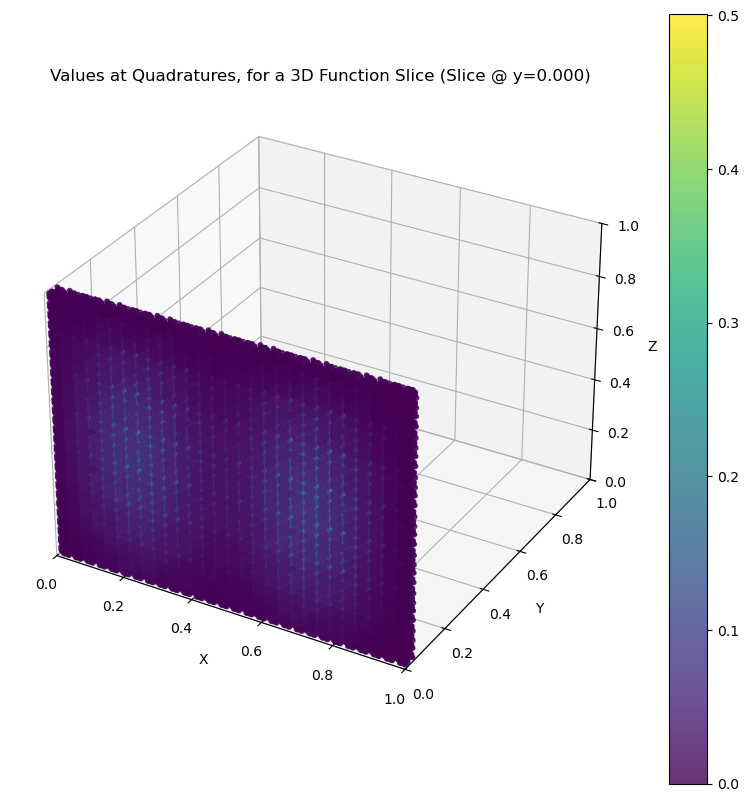

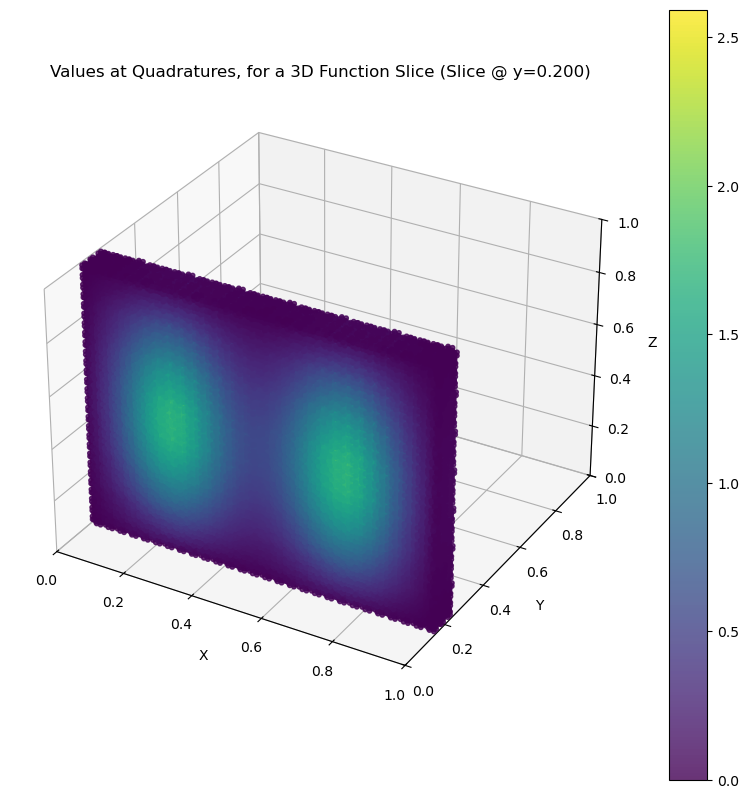

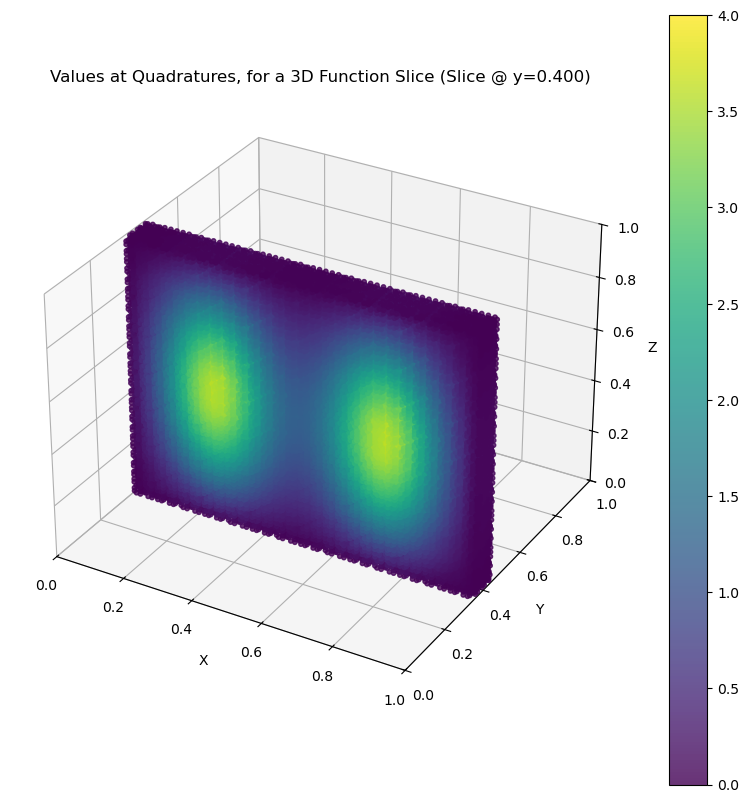

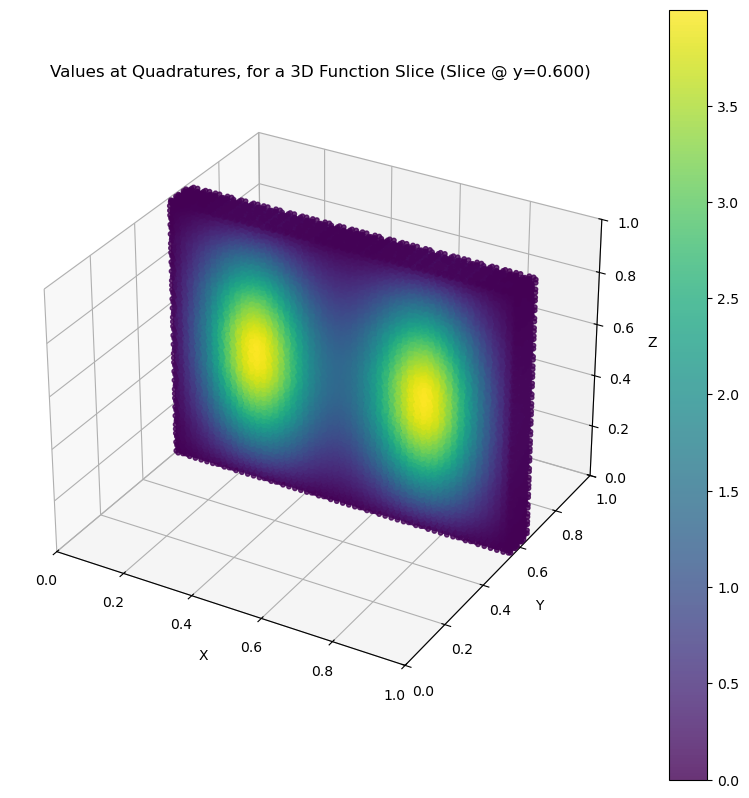

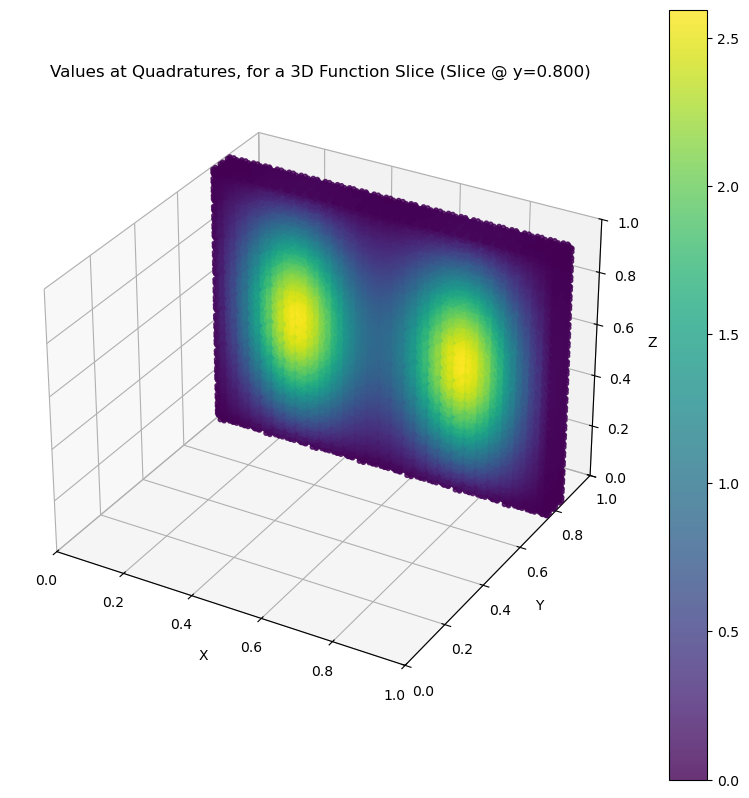

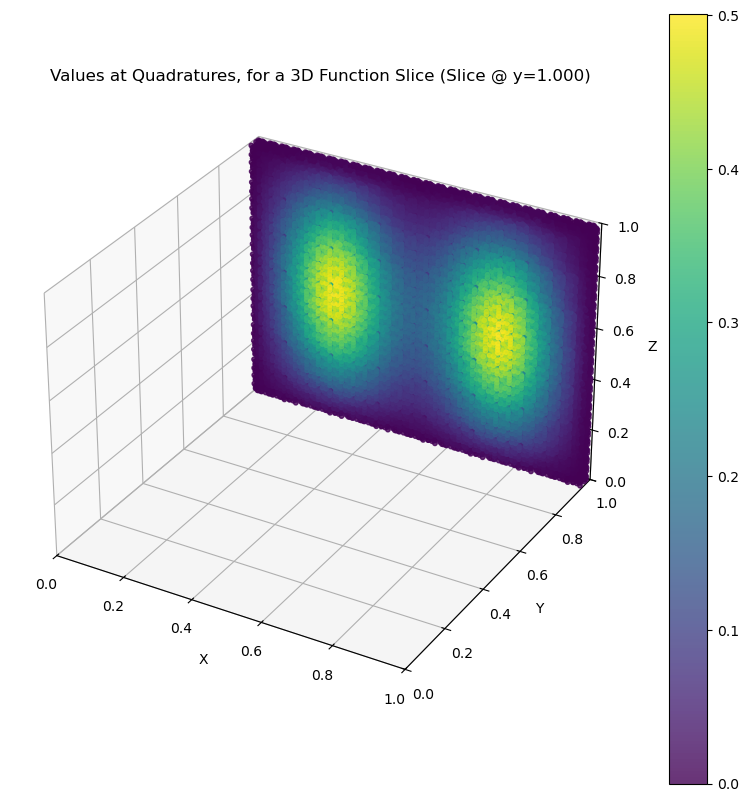

In [5]:
# Visualize Solution, in Slices
for i in range(6):
    femsystem.plot_interior_at_quad_3d_sliced(result,i/5,"y")